In [2]:
import argparse
from typing import Any, Dict
import os
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import MLFlowLogger
import matplotlib.pyplot as plt
import numpy as np
from utils import load_config
from model.Traj_UNet import Guide_UNet2
from utils.data_utils import TrafficDataset
from traffic.core import Traffic
from traffic.algorithms.generation import Generation
from sklearn.preprocessing import MinMaxScaler
from utils.condition_utils import load_conditions



def load_and_prepare_data(configs):
    """
    Load and prepare the dataset for the model.
    """
    dataset_config = configs['data']
    dataset = TrafficDataset.from_file(
        dataset_config["data_path"],
        features=dataset_config["features"],
        shape=dataset_config["data_shape"],
        scaler=MinMaxScaler(feature_range=(-1, 1)),
        info_params={
            "features": dataset_config["info_features"],
            "index": dataset_config["info_index"],
        },
        conditional_features = load_conditions(dataset_config) ,
        down_sample_factor=dataset_config["down_sample_factor"],
    )
    traffic = Traffic.from_file(dataset_config["data_path"])

    return dataset, traffic

def get_checkpoint_path(logger_config: Dict[str, Any]):
    """
    Get the path to the checkpoint file.
    """
    run_name = logger_config["run_name"]
    artifact_location = logger_config["artifact_location"]
    # check that the artifact location exists, otherwise raise an error
    if not os.path.exists(artifact_location):
        raise FileNotFoundError(f"Artifact directory {artifact_location} not found!")

    artifact_location = os.path.join(artifact_location, run_name)
    # check that artifact location exists, otherwise raise an error
    if not os.path.exists(artifact_location):
        raise FileNotFoundError(f"Artifact location {artifact_location} not found!")

    # get the "best_model.ckpt" file
    checkpoint = os.path.join(artifact_location, "best_model.ckpt")
    # check that the checkpoint exists, otherwise raise an error
    if not os.path.exists(checkpoint):
        raise FileNotFoundError(f"Checkpoint file {checkpoint} not found!")

    return checkpoint

def get_models(model_config, dataset_params, checkpoint_path, dataset_scaler):
    """
    Load the trained model and create the trajectory generation model.
    """
    #model = Guide_UNet2.load_from_checkpoint(checkpoint_path, map_location=torch.device('cuda'))
    model = Guide_UNet2.load_from_checkpoint(checkpoint_path, dataset_params = dataset_params, config = model_config)
    model.eval()  # Set the model to evaluation mode
    print("Model loaded with checkpoint!")
    
    """
    trajectory_generation_model = Generation(
        generation=trained_model,
        features=trained_model.hparams.dataset_params["features"],
        scaler=dataset_scaler,
    )
    """
    print("Trajectory generation model created!")

    return model

def get_config_data(config_path: str, data_path: str, artifact_location: str):
    configs = load_config(config_path)
    configs["data"]["data_path"] = data_path 
    configs["logger"]["artifact_location"] = artifact_location
    
    dataset, traffic = load_and_prepare_data(configs)

    condition_config = configs["data"]

    if dataset.conditional_features is None:
        conditions = load_conditions(condition_config, dataset)
    else:
        conditions = dataset.conditional_features

    return configs, dataset, traffic, conditions

def generate_samples(model, n, c_, t):
    raise NotImplementedError("Juhu")



config_file = "./configs/config.yaml"
data_path = "./data/OpenSky_EHAM_LIMC.pkl"
artifact_location= "./artifacts"
checkpoint = "./artifacts/AirDiffTraj/best_model.ckpt"


config = load_config(config_file)
checkpoint = f"./artifacts/AirDiffTraj/best_model.ckpt"
#checkpoint_path = get_checkpoint_path(config["logger"])
config, dataset, traffic, conditions = get_config_data(config_file, data_path, artifact_location)
config['model']["traj_length"] = dataset.parameters['seq_len']

model = get_models(config["model"], dataset.parameters, checkpoint, dataset.scaler)

_, con, cat = dataset[0]
print(con.shape, cat.shape)


# Download and load the training dataset
dataset_config = config["data"]
batch_size = dataset_config["batch_size"]
#train_dataset = FashionMNIST(root='./data', train=True, transform=transform)
x, con, cat = dataset[0]
con = con.reshape(1, -1)
cat = cat.reshape(1, -1)
#x = x.view(-1, 1, 28, 28)
n = 10
length = 155
samples = model.sample(n, con, cat, length)
print(samples)
print(samples.shape)



(6592, 620)
Continuous conditions:  2
Categorical conditions:  2
torch.Size([6592, 4]) torch.Size([6592, 2])
Model loaded with checkpoint!
Trajectory generation model created!
torch.Size([4]) torch.Size([2])
tensor([[[ 0.6679,  0.6146,  0.5581,  ...,  0.1307,  0.3154,  0.5809],
         [-0.9417, -0.9355, -0.9294,  ..., -0.6425, -0.3288, -0.0401],
         [-0.8962, -0.8682, -0.8368,  ..., -0.9595, -0.9828, -0.9924],
         [-0.3249, -0.0680, -0.1458,  ..., -0.5449, -0.5493, -0.5000]],

        [[ 0.6484,  0.5899,  0.5711,  ...,  0.1109,  0.2359,  0.5808],
         [-0.8953, -0.9051, -0.8655,  ..., -0.6408, -0.2988, -0.0428],
         [-0.9516, -0.9019, -0.8605,  ..., -0.9453, -0.9683, -1.0155],
         [-0.2626, -0.0261, -0.0996,  ..., -0.4671, -0.4762, -0.4317]],

        [[ 0.8557,  0.8743,  0.9216,  ...,  0.1996,  0.4199,  0.6533],
         [-1.0232, -0.9694, -0.9028,  ..., -0.6401, -0.3312, -0.0593],
         [-1.0319, -0.9126, -0.8468,  ..., -0.9903, -1.0153, -1.0239],
       

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import traffic.core as tc

def plot_from_array(t):
    # Check if the input data has the correct shape
    #if data.shape[1] != 2:
     #   raise ValueError("The second dimension of the array must have a size of 2 for x and y coordinates.")
    
  # Length of each x and y data series
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(10, 6))

    #for i in range(n):
        #x = data[i, 0, :]  # Extract the x values for the i-th series
        #y = data[i, 1, :]  # Extract the y values for the i-th series
        
        #plt.scatter(x, y, label=f'Series {i+1}')  # Plot each series with a label

    ax1 = fig.add_subplot(1, 1, 1)
    #ax1.coastlines()
    t.plot(ax1, alpha=0.1, color="red", linewidth=0.2)
    #ax1.add_feature(cartopy.feature.BORDERS, linestyle=":", alpha=1.0)
    #plt.xlabel('X values')
    #plt.ylabel('Y values')
    #plt.title('Plot of X and Y Data from Array')
    plt.show()

detached_s = samples.cpu().detach().numpy()


In [4]:
from traffic.algorithms.generation import Generation
trajectory_generation_model = Generation(
    generation=model,
    features=dataset.parameters['features'],
    scaler=dataset.scaler,
)

In [5]:
reconstructed_traf = trajectory_generation_model.build_traffic(
    detached_s,
    coordinates=dict(latitude=48.5, longitude=8.4),
    forward=False,
)

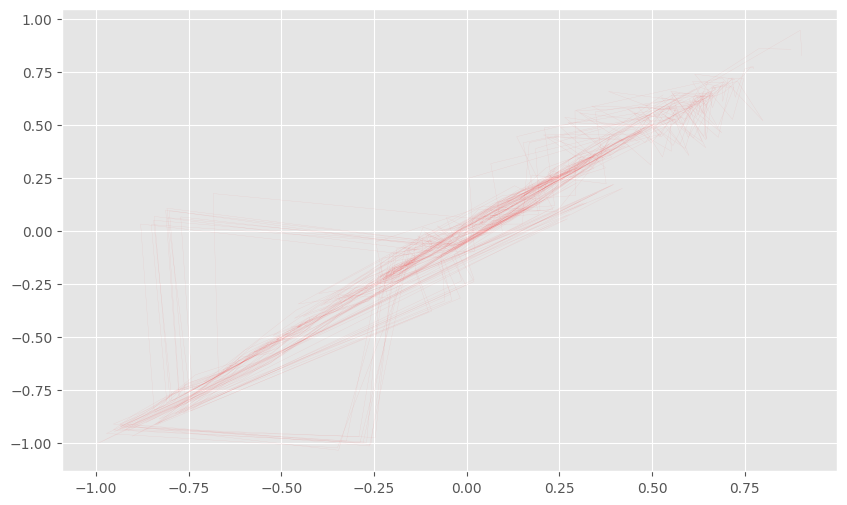

In [6]:
reconstructed_traf
plot_from_array(reconstructed_traf)

In [ ]:
import pandas as pd
def plot_from_array(data):
    # Check if the input data has the correct shape
    #if data.shape[1] != 2:
     #   raise ValueError("The second dimension of the array must have a size of 2 for x and y coordinates.")
    
  # Length of each x and y data series
    n = 10
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(10, 6))

    for i in range(n):
        x = data[i, 0, :]  # Extract the x values for the i-th series
        y = data[i, 1, :]  # Extract the y values for the i-th series
        
        plt.plot(x, y, label=f'Series {i+1}')  # Plot each series with a label

    #ax1 = fig.add_subplot(1, 1, 1)
    #ax1.coastlines()
    #t.plot(ax1, alpha=0.1, color="red", linewidth=0.2)
    #ax1.add_feature(cartopy.feature.BORDERS, linestyle=":", alpha=1.0)
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.title('Plot of X and Y Data from Array')
    plt.show()
print(detached_s[0].reshape(-1).shape)
descales_0 = dataset.scaler.inverse_transform(detached_s.reshape(10,-1)).reshape(10, 4, -1)
#print(descales_0[0, :2, :])

plot_from_array(detached_s[:, :2, :])

(620,)
